# TNG Preparation

This notebook takes a halo from the [TNG 300-1](https://www.tng-project.org/about/) simulation and generates simulated X-ray observations of it using [PyXSim](https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/). This observations may then be input into Bayes-X for demonstrating and testing the analysis proceedure.

## Halo Selection

Each run has 100 snapshots avaliable, at different redshifts. However, most snapshots are stored in a minified format that lacks some of the data we used to generate simulated observations. The snapshots retained in full are:

| Snap | Scale factor | Redshift |
|:----:|:------------:|:--------:|
|   2  |    0.0769    |    12    |
|   3  |    0.0833    |    11    |
|   4  |    0.0909    |    10    |
|   6  |      0.1     |     9    |
|   8  |    0.1111    |     8    |
|  11  |     0.125    |     7    |
|  13  |    0.1429    |     6    |
|  17  |    0.1667    |     5    |
|  21  |      0.2     |     4    |
|  25  |     0.25     |     3    |
|  33  |    0.3333    |     2    |
|  40  |      0.4     |    1.5   |
|  50  |      0.5     |     1    |
|  59  |    0.5882    |    0.7   |
|  67  |    0.6667    |    0.5   |
|  72  |    0.7143    |    0.4   |
|  78  |    0.7692    |    0.3   |
|  84  |    0.8333    |    0.2   |
|  91  |    0.9091    |    0.1   |
|  99  |       1      |     0    |

**Select halo here**

In [1]:
# Specify halo here
snapshot_id = 91
halo_id = 0


We load our API key and some helper functions. There's a basic cache becausing downloading cutouts takes a while.

There is possibly room to shrink the download by reducing the included fields (which can be incorporated in the api call) - this need futher investigation.

In [2]:
from os import getenv
from os import makedirs
from pathlib import Path
from uuid import uuid1

import requests
from tqdm.notebook import tqdm
from dotenv import load_dotenv

# Load TNG API key
# This looks for a .env file in this or a parent folder and
# loads environment variables from it.
# It does not override existing env vars.
load_dotenv()

# This gets it from the environment, which may have
# been modified by load_dotenv
# You could specify it here but don't commit it to git!
api_key = getenv("TNG_API_KEY")


# The files we are working with can be large so we'll make a basic
# cache to ease the load on the TNG Project servers.# type: ignore
# yt exports the types in a way that makes Pylance think they're private, leading to endless warnings.

def query_cache(filename: str, cache_path=Path(".cache")):
    """Look for file in cache"""
    file_path = Path(cache_path, filename)

    if file_path.is_file():
        return True, file_path
    else:
        return False, file_path


def update_cache(filename: str, content, cache_path=Path(".cache"), overwrite=False):
    """Add file to cache"""
    if not cache_path.is_dir():
        print(f"Making cache directory at {cache_path}")
        makedirs(cache_path)

    file_path = Path(cache_path, filename)

    if file_path.exists():
        if overwrite:
            print(f"Overwriting existing cache file {file_path}.")
        else:
            raise FileExistsError(f"Cache file {file_path} already exists.")

    write_mode = "wb"
    if isinstance(content, requests.Response):
        # Read binary/text from request and access content
        if "text" in content.headers["Content-Type"]:
            write_mode = "w"
        content = content.content
    elif isinstance(content, Path):
        # If we're passed a file just move it
        # This is good for large temp files we don't want to read into memory
        print(f"Moving {content} to cache as {file_path}")
        content.rename(file_path)
        return file_path

    with file_path.open(write_mode) as f:
        print(f"Caching {file_path}")
        f.write(content)

    return file_path


def get_halo(snapshot: int, halo: int, simulation="TNG300-1"):
    "Get local path to halo files, downloading it if required. Fetches cutout and `info.json`."
    base_url = f"http://www.tng-project.org/api/{simulation}/snapshots/{snapshot}/halos/{halo}/"
    headers = {"api-key": api_key}

    base_filename = f"{simulation}_snapshot{snapshot_id}_halo{halo_id}_"

    # First get info file for halo
    info_filename = base_filename + "_info.json"
    in_cache, info_path = query_cache(info_filename)

    if not in_cache:
        info_url = base_url + "info.json"
        print(f"Downloading info.json for halo from {info_url}")
        r = requests.get(info_url, headers=headers)  # type: ignore
        r.raise_for_status()  # raise exception on error
        info_path = update_cache(info_filename, r)

    # Then get the halo cutout
    halo_filename = base_filename + "_cutout.hdf5"
    in_cache, halo_path = query_cache(halo_filename)

    if not in_cache:
        tmp_file = Path(f"tmp_{uuid1()}.hdf5")
        cutout_url = base_url + "cutout.hdf5"
        print(f"Downloading cutout for halo from {cutout_url} to {tmp_file}")
        r = requests.get(cutout_url, headers=headers, stream=True)  # type: ignore
        # Fancy progress bar
        with tqdm.wrapattr(
            open(tmp_file, "wb"),
            "write",
            miniters=1,
            desc=f"Downloading cutout",
            total=int(r.headers.get("content-length", 0)),
        ) as fout:
            for chunk in r.iter_content(chunk_size=4096):
                fout.write(chunk)
        update_cache(halo_filename, tmp_file)

    return info_path, halo_path

Here we actually fetch the halo. This returns the path to the file location in the cache, downloading it if required. We grab both the HDF5 file and the info file for some precomputed values.

Values from `info.json` may be included somewhere in the cutout file - investigate.

In [3]:
info_path, halo_path = get_halo(snapshot_id, halo_id)

We then load it into Python with yt. Before doing so we define an additional field for solar metallicity. This is because, according to the [TNG data specification](https://www.tng-project.org/data/docs/specifications):
> [GFM_Metallicity is] the ratio MZ/Mtotal where MZ is the total mass all metal elements (above He). Is NOT in solar units. To convert to solar metallicity, divide by 0.0127 (the primordial solar metallicity).

PyXsim assumes solar metallicities, as best I can tell, so we need this correction.

In [4]:
import yt
from json import load as load_json

@yt.derived_field(name=("gas", "solar_metallicity"), sampling_type="particle", units="dimensionless")
def _solar_metallicity(field, data):
    return data['PartType0', 'GFM_Metallicity'] / 0.0127

with info_path.open() as f:
    info = load_json(f)

ds = yt.load(halo_path)

yt : [INFO     ] 2023-04-28 09:37:38,142 Calculating time from 9.096e-01 to be 3.934e+17 seconds
yt : [INFO     ] 2023-04-28 09:37:38,196 Parameters: current_time              = 3.934088884834162e+17 s
yt : [INFO     ] 2023-04-28 09:37:38,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-04-28 09:37:38,197 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-28 09:37:38,197 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2023-04-28 09:37:38,197 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-04-28 09:37:38,198 Parameters: current_redshift          = 0.09940180263022191
yt : [INFO     ] 2023-04-28 09:37:38,198 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2023-04-28 09:37:38,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2023-04-28 09:37:38,198 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-04-28 09:37:38,199 Parameters: hubble_const

## Plots

First we draw a few nice plots of the data. This helps us get an idea of the cluster shape and structure.

**Select projection normal here**

In [5]:
projection_normal = 'z' # vector normal to the plane of projection

In [85]:
# type: ignore
# Set these values here so the edge radius doesn't reset every time

# From the data specs:
# GroupPos = spatial position within the periodic box (of the particle with the minimum gravitational potential energy). Comoving coordinate.
from unyt import unyt_array, unyt_quantity
center = info['GroupPos']
center = unyt_array(center, 'kpccm/h', registry=ds.unit_registry)
r200 = unyt_quantity(info["Group_R_Crit200"], "kpccm/h", registry=ds.unit_registry)
r500 = unyt_quantity(info["Group_R_Crit500"], "kpccm/h", registry=ds.unit_registry)

dm = 1
r = 3 * r200
dr = 0.8 * r200

mt = ds.r[:,:,:].sum(('gas', 'mass'))
dx = mt

In [86]:
# This is a crude and slow way to find the cluster edge
sp1 = ds.sphere(center, (1, 'kpccm/h'))
while dx > 0.001*mt or abs(dr) > 50:
    r += dr
    sp2 = sp1
    sp1 = ds.sphere(center, r) 
    dx = sp1.sum(("gas", "mass")).in_units('Msun') - sp2.sum(("gas", "mass")).in_units('Msun')

    print(f"dx: {dx} at radius {r} with dr: {dr}")
    if dx == 0:
        dr = -abs(dr / 2)
    else:
        dr = min(abs(mt / dx * r), 1.5*r200)


sp = ds.sphere(center, r)

dx: 339633084663245.75 Msun at radius 6423.623999023437 kpccm/h with dr: 1352.34189453125 kpccm/h
dx: 3094610975024.75 Msun at radius 8959.26505126953 kpccm/h with dr: 2535.6410522460938 kpccm/h
dx: 0.0 Msun at radius 11494.906103515625 kpccm/h with dr: 2535.6410522460938 kpccm/h
dx: 0.0 Msun at radius 10227.085577392578 kpccm/h with dr: -1267.8205261230469 kpccm/h
dx: 0.0 Msun at radius 9593.175314331054 kpccm/h with dr: -633.9102630615234 kpccm/h
dx: 0.0 Msun at radius 9276.220182800293 kpccm/h with dr: -316.9551315307617 kpccm/h
dx: 0.0 Msun at radius 9117.742617034912 kpccm/h with dr: -158.47756576538086 kpccm/h
dx: 0.0 Msun at radius 9038.503834152221 kpccm/h with dr: -79.23878288269043 kpccm/h


In [87]:
def annotated_sphere_labeled(plot, center, radius, text):
    """Helper function to draw a circle on a plot and give it a radius on the right edge"""
    plot.annotate_sphere(center, radius=radius)
    radius_edge = center + radius / 2
    plot.annotate_text(radius_edge, text=text)

### Gas Density


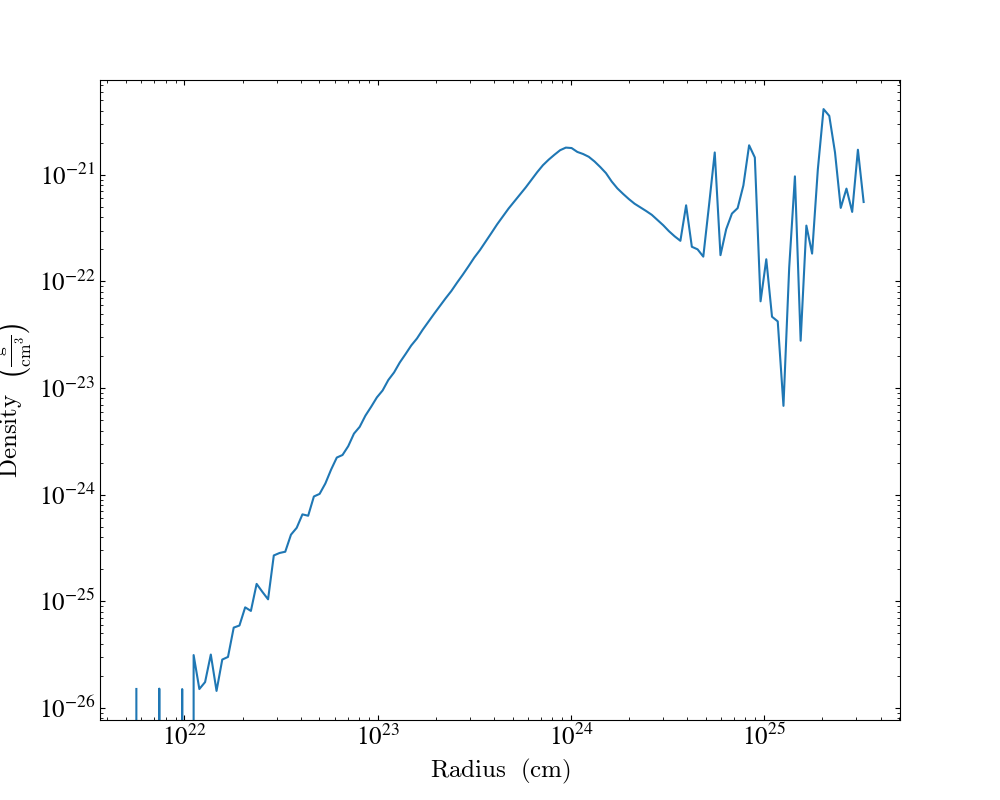

In [88]:
density_prof = yt.ProfilePlot(sp, ("gas", "radius"), [("gas", "density")], weight_field=None, n_bins=128)
density_prof.show()

yt : [INFO     ] 2023-04-28 10:47:30,136 xlim = 38785.658239 47824.162073
yt : [INFO     ] 2023-04-28 10:47:30,136 ylim = 43829.494177 52867.998011
yt : [INFO     ] 2023-04-28 10:47:30,137 xlim = 38785.652972 47824.155579
yt : [INFO     ] 2023-04-28 10:47:30,137 ylim = 43829.488225 52867.990831
yt : [INFO     ] 2023-04-28 10:47:30,138 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



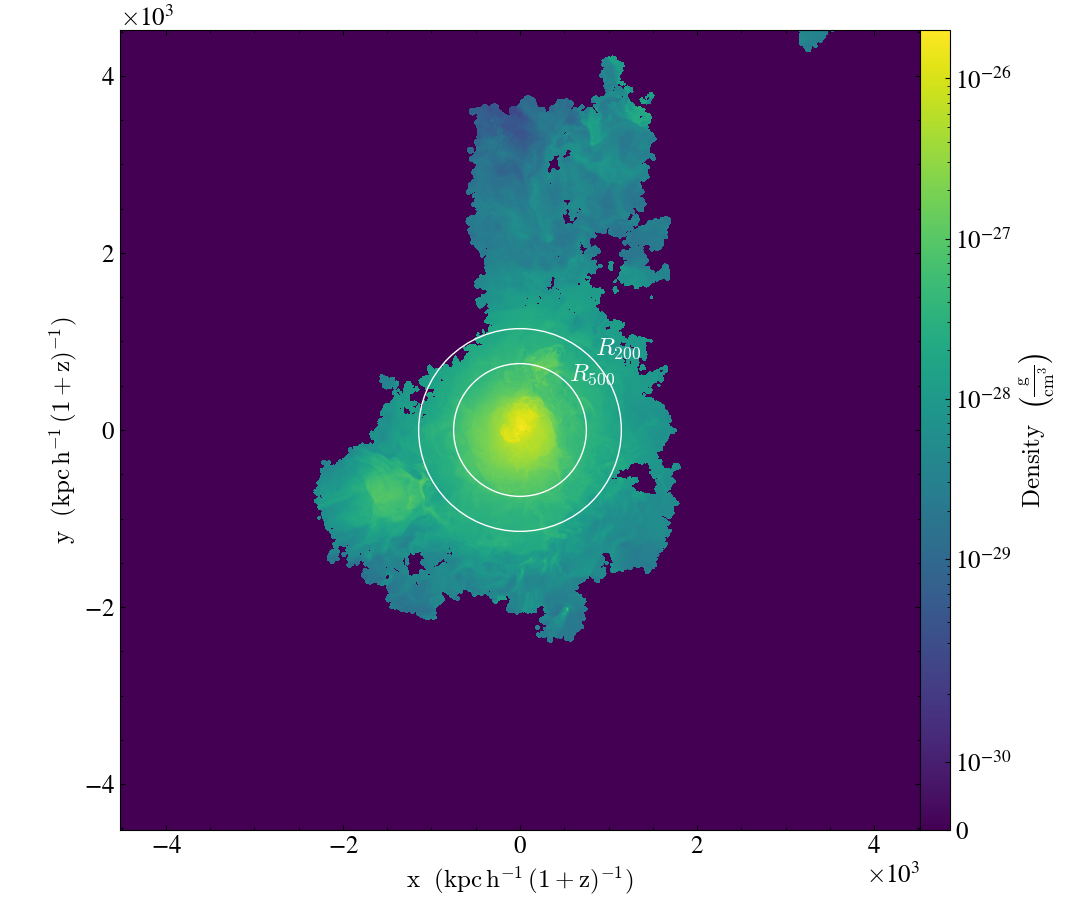

In [89]:
density_slc = yt.SlicePlot(ds, projection_normal, ("gas", "density"), center=center, width=r)
annotated_sphere_labeled(density_slc, center, r200, "$R_{200}$")
annotated_sphere_labeled(density_slc, center, r500, "$R_{500}$")
density_slc.set_cmap(('gas', 'density'), 'viridis')
density_slc.show()
# density_slc.save()

### Gas Temperature

yt : [INFO     ] 2023-04-28 10:54:44,754 xlim = 34266.406322 52343.413990
yt : [INFO     ] 2023-04-28 10:54:44,754 ylim = 39310.242260 57387.249928
yt : [INFO     ] 2023-04-28 10:54:44,755 xlim = 34266.401669 52343.406882
yt : [INFO     ] 2023-04-28 10:54:44,755 ylim = 39310.236921 57387.242135
yt : [INFO     ] 2023-04-28 10:54:44,756 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



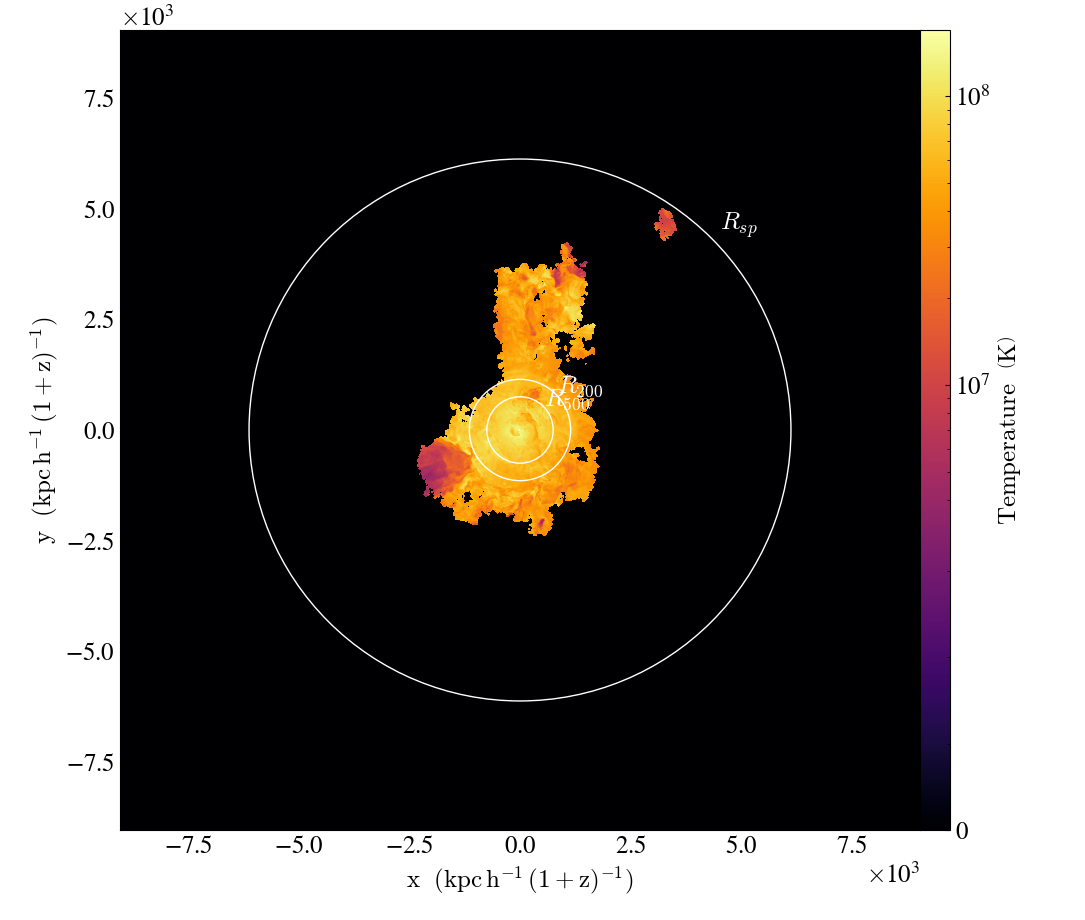

In [102]:
# yt provides syntax to make multiple slice plots at once but it has a bug when we then annotate it.
temperature_slc = yt.SlicePlot(ds, projection_normal, ("gas", "temperature"), center=center, width=2*r)
annotated_sphere_labeled(temperature_slc, center, r200, "$R_{200}$")
annotated_sphere_labeled(temperature_slc, center, r500, "$R_{500}$")
annotated_sphere_labeled(temperature_slc, center, r, "$R_{sp}$")
temperature_slc.set_cmap(('gas', 'temperature'), 'inferno')
temperature_slc.show()
# temperature_slc.save()

## Gas Column Density

yt : [INFO     ] 2023-04-28 10:47:58,116 xlim = 38785.658239 47824.162073
yt : [INFO     ] 2023-04-28 10:47:58,117 ylim = 43829.494177 52867.998011
yt : [INFO     ] 2023-04-28 10:47:58,118 xlim = 38785.652972 47824.155579
yt : [INFO     ] 2023-04-28 10:47:58,118 ylim = 43829.488225 52867.990831
yt : [INFO     ] 2023-04-28 10:47:58,119 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



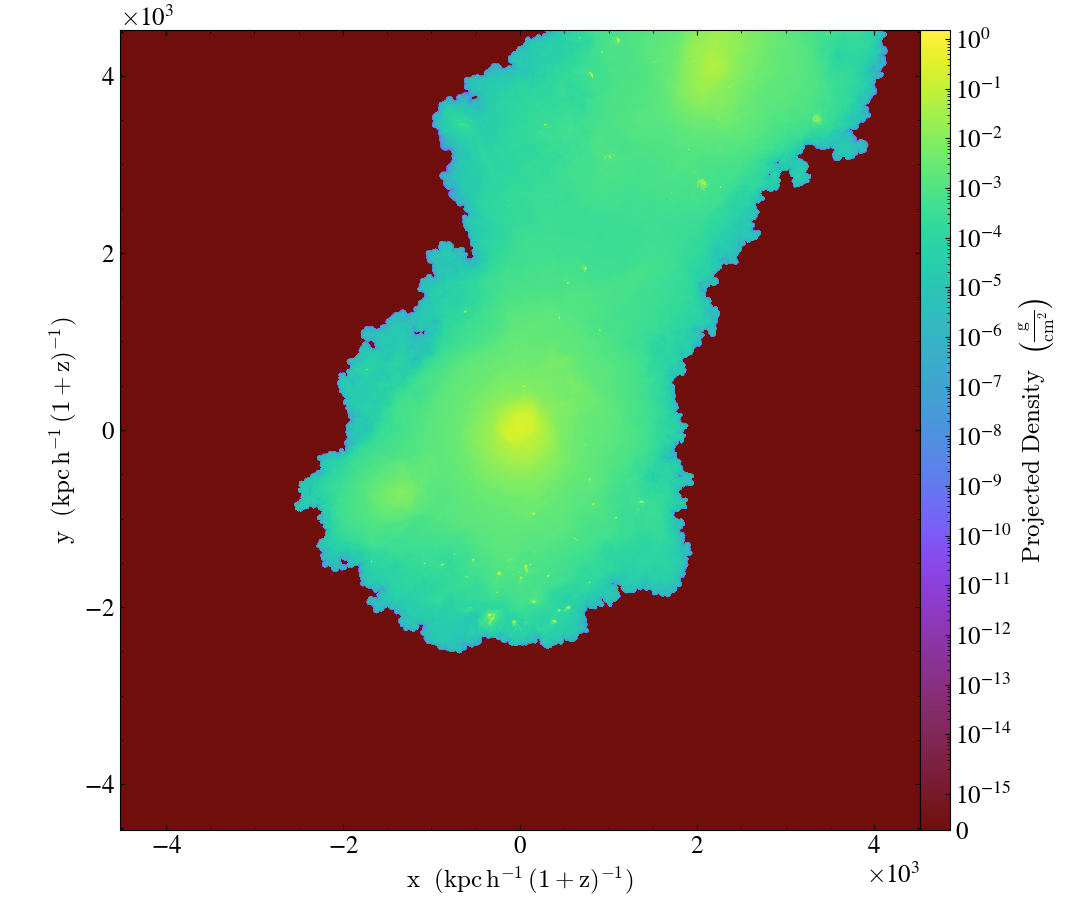

In [91]:
from yt import ProjectionPlot
proj = ProjectionPlot(ds, projection_normal, ("gas", "density"), center=center, width=r)
proj.show()

In [92]:
import pyxsim
import soxs

In [93]:
energy_range = (0.3, 7.0)
nbins = 400 # 1100 for detail, but slow
prefix = 'tng_'
source_exp_time = (300., "ks") # exposure time
area = (1000, "cm**2") # collecting area
redshift = ds.current_redshift # type: ignore

In [94]:
from math import atan, sqrt

pos = (atan(center[0]/center[2]), atan(center[1] / sqrt(center[0]**2 + center[2]**2))) # (RA, Dec)

In [95]:
var_elem = {
    elem: ("gas", f"{elem}_fraction")
    for elem in
    ["C", "Fe", "H", "He", "Mg", "N", "Ne", "O", "Si"]
}

# Sources uses larger energy range than observations
# Convert metallicity to solar values
source_model = pyxsim.CIESourceModel('apec', emin=0.1, emax=11.0, nbins=nbins, Zmet=('gas', 'solar_metallicity'), var_elem=var_elem)

pyxsim : [INFO     ] 2023-04-28 10:48:12,779 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-04-28 10:48:12,780 kT_max = 64 keV


In [96]:
xray_fields = source_model.make_source_fields(ds, *energy_range)
print(xray_fields)

pyxsim : [INFO     ] 2023-04-28 10:48:12,801 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-04-28 10:48:12,801 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [WARNING  ] 2023-04-28 10:48:16,001 Field ('gas', 'xray_luminosity_0.3_7.0_keV') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2023-04-28 10:48:16,003 Field ('gas', 'xray_emissivity_0.3_7.0_keV') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2023-04-28 10:48:16,006 Field ('gas', 'xray_photon_emissivity_0.3_7.0_keV') already exists. To override use `force_override=True`.


[('gas', 'xray_emissivity_0.3_7.0_keV'), ('gas', 'xray_luminosity_0.3_7.0_keV'), ('gas', 'xray_photon_emissivity_0.3_7.0_keV')]


In [97]:
n_photons, n_cells = pyxsim.make_photons(prefix + "photons", sp, redshift, area, source_exp_time, source_model)

pyxsim : [INFO     ] 2023-04-28 10:48:16,052 Cosmology: h = 0.6774, omega_matter = 0.3089, omega_lambda = 0.6911
pyxsim : [INFO     ] 2023-04-28 10:48:16,053 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-04-28 10:48:16,053 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/28834570 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-04-28 10:54:10,715 Finished generating photons.
pyxsim : [INFO     ] 2023-04-28 10:54:10,716 Number of photons generated: 41743415
pyxsim : [INFO     ] 2023-04-28 10:54:10,716 Number of cells with photons: 12098626


In [98]:
n_events = pyxsim.project_photons(prefix + "photons", prefix + "events", projection_normal, pos, absorb_model="tbabs", nH=0.022)
events = pyxsim.EventList(prefix + "events.h5")
events.write_to_simput(prefix, overwrite=True)

pyxsim : [INFO     ] 2023-04-28 10:54:10,766 Foreground galactic absorption: using the tbabs model and nH = 0.022.


Projecting photons from cells/particles :   0%|          | 0/12098626 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-04-28 10:54:21,337 Detected 23624825 events.
soxs : [WARNING  ] 2023-04-28 10:54:22,024 Overwriting tng__phlist.fits.
soxs : [INFO     ] 2023-04-28 10:54:22,753 Writing source 'tng_' to tng__phlist.fits.


In [99]:
bg_exp_time = (300., "ks")

In [100]:
soxs.make_background_file(prefix + "bg.fits", bg_exp_time, "chandra_acisi_cy0", pos, overwrite=True)
soxs.instrument_simulator(prefix + "_simput.fits", prefix + "obs_evt.fits", bg_exp_time, "chandra_acisi_cy0",
                          pos, overwrite=True, bkgnd_file=prefix+'bg.fits')
soxs.write_image(prefix + "obs_evt.fits", prefix + "obs_img.fits", emin=0.3, emax=7.0, overwrite=True)

soxs : [INFO     ] 2023-04-28 10:54:24,418 Adding in point-source background.
soxs : [INFO     ] 2023-04-28 10:54:24,972 Detecting events from source ptsrc_bkgnd.
soxs : [INFO     ] 2023-04-28 10:54:24,973 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2023-04-28 10:54:24,993 Pixeling events.
soxs : [INFO     ] 2023-04-28 10:54:25,006 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2023-04-28 10:54:25,074 42301 events were detected from the source.
soxs : [INFO     ] 2023-04-28 10:54:25,079 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/42301 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-28 10:54:25,225 Generated 42301 photons from the point-source background.
soxs : [INFO     ] 2023-04-28 10:54:25,226 Adding in astrophysical foreground.


Convolving spectrum :   0%|          | 0/937 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-28 10:54:25,686 Adding in instrumental background.
soxs : [INFO     ] 2023-04-28 10:54:25,719 Making 16113 events from the galactic foreground.
soxs : [INFO     ] 2023-04-28 10:54:25,719 Making 363927 events from the instrumental background.
soxs : [INFO     ] 2023-04-28 10:54:25,742 Writing events to file tng_bg.fits.
soxs : [INFO     ] 2023-04-28 10:54:25,873 Making observation of source in tng_obs_evt.fits.
soxs : [INFO     ] 2023-04-28 10:54:26,973 Detecting events from source tng_.
soxs : [INFO     ] 2023-04-28 10:54:26,974 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2023-04-28 10:54:29,992 Pixeling events.
soxs : [INFO     ] 2023-04-28 10:54:31,488 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2023-04-28 10:54:35,199 3732535 events were detected from the source.
soxs : [INFO     ] 2023-04-28 10:54:35,948 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/3732535 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-28 10:54:38,105 Adding background events from the file tng_bg.fits.
soxs : [INFO     ] 2023-04-28 10:54:38,124 Adding 422341 background events from tng_bg.fits.
soxs : [INFO     ] 2023-04-28 10:54:38,190 Writing events to file tng_obs_evt.fits.
soxs : [INFO     ] 2023-04-28 10:54:39,563 Observation complete.


(<Figure size 1000x1000 with 2 Axes>, <WCSAxes: >)

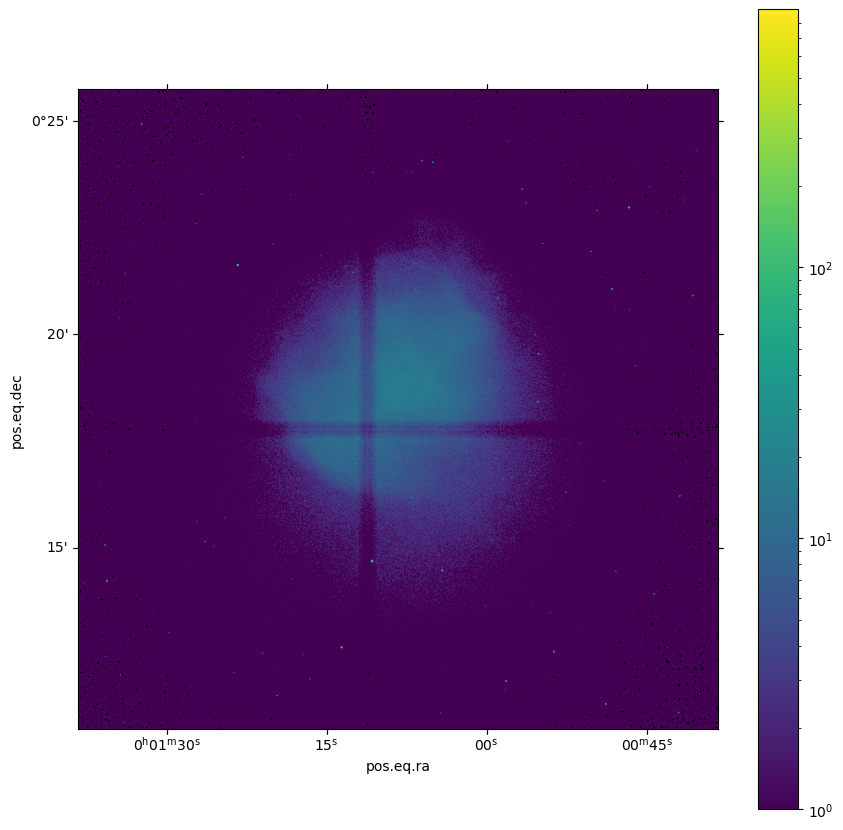

In [101]:
soxs.plot_image(prefix + "obs_img.fits", stretch='log', cmap='viridis', width=0.25)